In [2]:
## Adding the .simplify_full() command may give cleaner functions to look at, but drastically increases the runtime (from 0.5 sec to more than 4 min), and, most importantly, causes completely unstable computations that ruin the precision (for unknown reasons).
import time
import numpy as np
from sage.functions.piecewise import piecewise
from sage.all import sign

prec = 100
RBF = RealBallField(prec)
RIF = RealIntervalField(prec)
var('x')
assume(x, 'real')
var('y')
assume(y, 'real')

n_derivs=10  # Number of derivatives to compute


W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime
b = (3*x)/2 + W
a_derivs = [a]
a_derivs_0=[RBF(a_derivs[0].taylor(x,0,0))]
b_derivs = [b]
b_derivs_0=[RBF(b_derivs[0].taylor(x,0,0))]
for k in range(1, n_derivs):
    a_derivs.append(diff(a, x, k))
    a_derivs_0.append(RBF(a_derivs[k].taylor(x,0,0)))
    b_derivs.append(diff(b, x, k))
    b_derivs_0.append(RBF(b_derivs[k].taylor(x,0,0)))


phi_0 = -a_derivs[0] + b_derivs[1]/2 + a_derivs[2]/2 - a_derivs[4]/2 + a_derivs[6]/2
phi_1 = -a_derivs[0] - b_derivs[1]/2 + 2*a_derivs[2] + b_derivs[3]/2 - 3*a_derivs[4] - b_derivs[5]/2
phi_2 = -a_derivs[0] - (3/2)*b_derivs[1] + (9/2)*a_derivs[2] + (5/2)*b_derivs[3] 
phi_3 = -a_derivs[0] - (5/2)*b_derivs[1] # corresponds to the sign in the inequality
phi_list = [phi_0, phi_1, phi_2, phi_3]

phi_0_0 = -a_derivs_0[0] + b_derivs_0[1]/2 + a_derivs_0[2]/2 - a_derivs_0[4]/2 + a_derivs_0[6]/2
phi_1_0 = -a_derivs_0[0] - b_derivs_0[1]/2 + 2*a_derivs_0[2] + b_derivs_0[3]/2 - 3*a_derivs_0[4] - b_derivs_0[5]/2
phi_2_0 = -a_derivs_0[0] - (3/2)*b_derivs_0[1] + (9/2)*a_derivs_0[2] + (5/2)*b_derivs_0[3]
phi_3_0 = -a_derivs_0[0] - (5/2)*b_derivs_0[1]  
phi_list_0 = [phi_0_0, phi_1_0, phi_2_0, phi_3_0]


# Base Fourier function
f = (pi/4) * exp(-2*pi*abs(x)) * (2*(pi**2)*(x**2) + 3*pi*abs(x) + 3/2)
lambda_0 = f
lambda_1 = -diff(f, x)
lambda_2 = -diff(f, x, 2)
lambda_3 = 2*diff(f, x, 3)
lambda_4 = diff(f, x, 4)
lambda_5 = diff(f, x, 5)
lambda_6 = diff(f, x, 6)
lambda_list = [lambda_0,lambda_1,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6]
lambda_list_0 = [limit(lambda_0,x=0),limit(lambda_1,x=0),limit(lambda_2,x=0),limit(lambda_3,x=0),limit(lambda_4,x=0),limit(lambda_5,x=0),limit(lambda_6,x=0)]


M_0 = (lambda_list[0](x=x - y) * phi_list[0](x=y))
M_1 = (lambda_list[1](x=x - y) * diff(phi_list[1], x)(x=y) + lambda_list[2](x=x - y) * phi_list[1](x=y))
M_2 = (lambda_list[3](x=x - y) * diff(diff(phi_list[2], x),x)(x=y) +lambda_list[3](x=x - y) * diff(phi_list[2], x)(x=y)+ lambda_list[4](x=x - y) * phi_list[2](x=y))
M_list=[M_0,M_1,M_2]


# Converts symbolic functions to numerical ones that have RealBallField/RealIntervalField for domain
# and repair the numerical singularities at 0

def smooth_fast_callable(f,x,zero_value=RBF(0)):
    f_fast = fast_callable(f, vars=[x], domain=RBF)
    def f_modified(ball):
        return RBF(zero_value) if abs(RBF(ball).center()) <= 2**(-prec+1) else f_fast(RBF(ball)) # Sets the sensibility to be equal to the precision of the field
    return f_modified

a_funcs = [smooth_fast_callable(a_derivs[k],x,a_derivs_0[k]) for k in range(n_derivs)]
b_funcs = [smooth_fast_callable(b_derivs[k],x,b_derivs_0[k]) for k in range(n_derivs)]
phi_funcs = [smooth_fast_callable(phi_list[k],x,phi_list_0[k]) for k in range(4)]
lambda_funcs = [smooth_fast_callable(lambda_list[k],x,lambda_list_0[k]) for k in range(7)]

phi_1_d1_0=diff(phi_list[1],x).taylor(x,0)
phi_1_d1_func=smooth_fast_callable(diff(phi_list[1],x),x,phi_1_d1_0)

phi_2_d1_0=diff(phi_list[2],x).taylor(x,0)
phi_2_d1_func=smooth_fast_callable(diff(phi_list[2],x),x,phi_2_d1_0)
phi_2_d2_0=diff(diff(phi_list[2],x),x).taylor(x,0)
phi_2_d2_func=smooth_fast_callable(diff(diff(phi_list[2],x),x),x,phi_2_d2_0)

def M_0_func(ball1,ball2):
   return lambda_funcs[0](ball1-ball2)*phi_funcs[0](ball2)
    
def M_1_func(ball1, ball2):
    return (lambda_funcs[1](ball1-ball2) * phi_1_d1_func(ball2) + lambda_funcs[2](ball1-ball2) * phi_funcs[1](ball2))

def M_2_func(ball1, ball2):
    return (lambda_funcs[3](ball1-ball2) * phi_2_d2_func(ball2) + lambda_funcs[3](ball1-ball2) * phi_2_d1_func(ball2) + lambda_funcs[4](ball1-ball2) * phi_funcs[2](ball2))

M_funcs=[M_0_func,M_1_func,M_2_func]

In [25]:
def repair_symbolic(f, x):
    """
    Retourne un piecewise reprenant f, avec les singularités supprimées par continuité.
    - on simplifie d'abord f comme fraction rationnelle ;
    - on retrouve les racines du dénominateur original ;
    - on remplace f(a) par lim_{x->a} f(x).
    """
    # 1) fraction simplifiée
    f_simpl = f.simplify_full()
    # 2) racines du dénominateur
    D = f.denominator()
    racines = [r[0] for r in solve(D == 0, x)]
    # 3) préparer les clauses pour piecewise
    clauses = []
    for a in racines:
        L = limit(f, x=a)
        clauses.append((L, x == a))
    # 4) construire la fonction réparée
    return piecewise(clauses, default=f_simpl)

def repair_symbolic_extended(f, x):
    """
    - Simplifie f pour éliminer 0/0 (simplify_rational).
    - Trouve les racines du dénominateur via denom.roots(x).
    - Remplace f(a) par lim_{x->a} f(x) pour chaque racine a.
    - Remplace x/abs(x) par sign(x), avec sign(0)=0.
    """
    # 1) simplification rationnelle
    f_simpl = f.simplify_rational()
    # 2) racines du dénominateur
    denom = f.denominator()
    # roots() renvoie [(valeur, multiplicite), …]
    sing_pts = [rt for rt, mult in denom.roots(x)]
    # 3) construction des clauses (limites)
    clauses = [(limit(f, x=a), x == a) for a in sing_pts]
    # 4) cas x/|x|
    if f_simpl.has(abs(x)):
        f_simpl = f_simpl.replace(x/abs(x), sign(x))
        clauses.append((0, x == 0))
    # 5) retour en piecewise
    return piecewise(clauses, default=f_simpl)



def make_safe_numeric(f, x, tol=1e-12):
    """
    Retourne une fonction Python safe_f(t) qui :
      - gère en priorité le cas x/abs(x) → sign(t) (avec sign(0)=0)
      - sinon simplify_rational + extraction des racines du dénominateur
      - pour chaque racine a où limit(f,x=a) fonctionne, on mémorise L=f(a) par continuité
      - à l'évaluation :
         * si |t-a|<tol pour l'une des racines, renvoie L
         * sinon f_simpl(x=t).n()
    """
    # 0) cas spécial x/abs(x)
    if f == x/abs(x):
        def safe_sign(t):
            return 1.0 if t>0 else (-1.0 if t<0 else 0.0)
        return safe_sign

    # 1) simplification rationnelle
    f_simpl = f.simplify_rational()
    # 2) collecte des racines du dénominateur
    denom = f.denominator()
    roots = [rt for rt, _ in denom.roots(x)]
    # 3) calcul des limites (skipping celles qui plantent)
    lims = {}
    for a in roots:
        try:
            L = limit(f, x=a)
            lims[float(a)] = float(L)
        except (TypeError, ValueError):
            # on ignore ce point
            continue

    # 4) wrapper d'évaluation
    def safe_f(t):
        # 4a) test de proximité des racines
        for a, L in lims.items():
            if abs(t - a) < tol:
                return L
        # 4b) évaluation numérique
        return float(f_simpl.subs(x=t).n())

    return safe_f


In [28]:
# (1) f1(x) = (1-x)*sin(pi*x)/(x*(1-x))  → singularités en 0 et 1
f1 = (1 - x)*sin(pi*x)/(x*(1-x))
safe_f1 = make_safe_numeric(f1, x)

# (2) f2(x) = x/|x|  → saut en 0
f2 = x/abs(x)
safe_f2 = make_safe_numeric(f2, x)

print([ safe_f1(t) for t in [0, 1, 0.3] ])
#    [3.14159265358979, 0.0, sin(0.3*pi)/0.3 ≈ 3.14159…]
print([ safe_f2(t) for t in [-2, -0.1, 0, 0.1, 2] ])
#    [-1.0, -1.0, 0.0, 1.0, 1.0]


[3.141592653589793, 0.0, 2.696723314583158]
[-1.00000000000000, -1.00000000000000, 0.000000000000000, 1.00000000000000, 1.00000000000000]


In [13]:
f1 = (1 - x)*sin(pi*x)/(x*(1-x))
f2 = x/abs(x)



R1 = repair_symbolic_extended(f1, x)
R2 = repair_symbolic_extended(f2, x)

# tests
[R1(t) for t in [0, 1, 0.5]], [R2(t) for t in [-2, -0.1, 0, 0.1, 2]]

ValueError: pi does not determine real interval

In [12]:
def grid(A,n,B=NaN,offset=0):
    if B==NaN:
        B=A ; A=-B
    if n==1:
        return [A]
    return ([A + (B-A)*(i+offset)/(n-1) for i in range(n)])

def grid_concentrated(A, B, y, n):
    t = [-1+ 2*i/(n-1) for i in range(n)]
    t_concentres = [xi * abs(xi)**0.5 for xi in t]
    largeur_gauche = y - A
    largeur_droite = B - y
    points = []
    for xi in t_concentres:
        if xi < 0:
            val = y + xi * largeur_gauche
        else:
            val = y + xi * largeur_droite
        points.append(RBF(val))
    return points

def riemann_sum(f, y1, y2, n):
    y_points = grid(y1,n,y2)
    def g(x):
        return sum(RBF(delta) * RBF(f(x, y_i)) for y_i in y_points)
    return y_points,g

def riemann_integral(f, x1, x2, y1, y2, n):

    dx = (RBF(x2) - RBF(x1))/n
    dy = (RBF(y2) - RBF(y1))/n

    total = RBF(0)
    for i in range(n):
        for j in range(n):
            xi = RBF(x1) + i*dx
            yj = RBF(y1) + j*dy
            total += f(xi, yj) * dx * dy
            if f(xi,yj).is_NaN():
                print(yj.center())
                print()
            sys.stdout.write(f"\rIntegral computation : {int(((n*i+j) / (n**2)) * 100)}%") # Progress bar
            sys.stdout.flush()
    sys.stdout.write("\r" + " " * 30 + "\r")
    sys.stdout.flush()
    return total 

def delta_squared(K1,K2):
    def f(x,y):
        return (K1(x,y)-K2(x,y))**2
    return f

def delta_abs(K1,K2):
    def f(x,y):
        return abs(K1(x,y)-K2(x,y))
    return f

def delta_log(K1,K2):
    def f(x,y):
        return log(1+abs(K1(x,y)-K2(x,y)))
    return f

In [48]:
def G_even(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2)) + exp(-(q+center)**2/(2 * sig**2))

def G(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2))

var('p, q, r')
fG = fast_callable(G(p, q, r), vars=[p, q, r], domain=RR)
fG_even = fast_callable(G_even(p, q, r), vars=[p, q, r], domain=RR)

def fit_num(func, basis_pts, train_pts, sigma=1/2, basis_type='G'):
    true_vals = vector(RR, [func(x) for x in train_pts])    
    basis_num=len(basis_pts)
    train_num=len(train_pts)
    var('p, q, r')
    if basis_type == 'G':
        M_norm = matrix(RR, train_num, basis_num, lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    elif basis_type == 'G_even':
        M_norm = matrix(RR, train_num, basis_num, lambda i, j: fG_even(train_pts[i], basis_pts[j], sigma))
    cond = np.linalg.cond(M_norm)
    if cond > 1e8:
        print(f"⚠️ Warning: condition number = {cond}, result may be unstable.")

    # use numpy least squares to fit
    result, residual, rk, sth = np.linalg.lstsq(M_norm, true_vals, rcond=None)
    mse = np.mean((np.dot(M_norm, result) - true_vals)**2)
    #print(f"Mean squared error: {mse}")
    
    # calculate the approximate function
    if basis_type == 'G':
        approx_fun = sum([result[j] * G(x, basis_pts[j], sigma) for j in range(basis_num)])
    elif basis_type == 'G_even':
        approx_fun = sum([result[j] * G_even(x, basis_pts[j], sigma) for j in range(basis_num)])        
    
    return result, approx_fun, mse

In [49]:
def fit_num_ridge(func, basis_pts, train_pts, sigma=1/2, basis_type='G', alpha=None):
    true_vals = vector(RR, [func(x) for x in train_pts])    
    basis_num = len(basis_pts)
    train_num = len(train_pts)

    if basis_type == 'G':
        M = matrix(RR, train_num, basis_num, lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    elif basis_type == 'G_even':
        M = matrix(RR, train_num, basis_num, lambda i, j: fG_even(train_pts[i], basis_pts[j], sigma))

    M_np = np.array(M)
    y_np = np.array(true_vals)

    # Calcul du conditionnement
    cond = np.linalg.cond(M_np)
    if alpha is None:
        alpha = max(1e-8, 1 / cond)

    if cond > 1e8:
        print(f"⚠️  Matrice mal conditionnée : cond = {cond:.2e}. Régularisation activée avec alpha = {alpha:.2e}")

    # Ridge regression : (MᵗM + αI)x = Mᵗy
    MtM = M_np.T @ M_np
    MtF = M_np.T @ y_np
    I = np.identity(basis_num)

    result = np.linalg.solve(MtM + alpha * I, MtF)

    approx_vals = M_np @ result
    mse = np.mean((approx_vals - y_np)**2)

    if basis_type == 'G':
        approx_fun = sum([result[j] * G(x, basis_pts[j], sigma) for j in range(basis_num)])
    elif basis_type == 'G_even':
        approx_fun = sum([result[j] * G_even(x, basis_pts[j], sigma) for j in range(basis_num)])

    return result, approx_fun, mse


⚠️ Warning: condition number = 1.4495634960217894e+17, result may be unstable.
⚠️  Matrice mal conditionnée : cond = 1.45e+17. Régularisation activée avec alpha = 1.00e-8
MSE (train) sans régularisation : 8.23e-02
MSE (train) avec régularisation  : 2.00e-01
MSE (test) sans régularisation : 7.79e+12
MSE (test) avec régularisation  : 4.41e-01


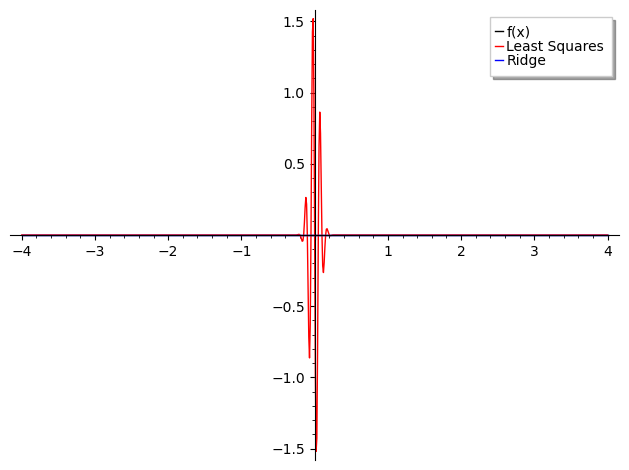

In [50]:
# --- Fonction cible ---
f = lambda x: sin(5*x) * exp(-x^2)

# --- Paramètres du test ---
basis_pts = [i * 0.01 for i in range(-10, 11)]   # très proches → mal conditionné
train_pts = [i * 0.05 for i in range(-20, 21)]   # points d'entraînement
sigma = 0.05

# --- Exécution des deux fits ---
res_ls, approx_ls_expr, mse_ls = fit_num(f, basis_pts, train_pts, sigma=sigma, basis_type='G')
res_ridge, approx_ridge_expr, mse_ridge = fit_num_ridge(f, basis_pts, train_pts, sigma=sigma, basis_type='G')

print(f"MSE (train) sans régularisation : {mse_ls:.2e}")
print(f"MSE (train) avec régularisation  : {mse_ridge:.2e}")

# --- Erreur sur un jeu de test ---
test_pts = [i * 0.025 for i in range(-40, 41)]
true_test = [f(x) for x in test_pts]

approx_ls_func = fast_callable(approx_ls_expr, vars=[x], domain=RR)
approx_ridge_func = fast_callable(approx_ridge_expr, vars=[x], domain=RR)

approx_test_ls = [approx_ls_func(xval) for xval in test_pts]
approx_test_ridge = [approx_ridge_func(xval) for xval in test_pts]

mse_test_ls = np.mean((np.array(approx_test_ls) - np.array(true_test))**2)
mse_test_ridge = np.mean((np.array(approx_test_ridge) - np.array(true_test))**2)

print(f"MSE (test) sans régularisation : {mse_test_ls:.2e}")
print(f"MSE (test) avec régularisation  : {mse_test_ridge:.2e}")

# --- Tracé des courbes ---
plot_pts = [x/100 for x in range(-400, 401)]
true_vals = [f(x) for x in plot_pts]
approx_vals_ls = [approx_ls_func(xval) for xval in plot_pts]
approx_vals_ridge = [approx_ridge_func(xval) for xval in plot_pts]

p1 = list_plot(list(zip(plot_pts, true_vals)), plotjoined=True, color='black', legend_label='f(x)')
p2 = list_plot(list(zip(plot_pts, approx_vals_ls)), plotjoined=True, color='red', legend_label='Least Squares')
p3 = list_plot(list(zip(plot_pts, approx_vals_ridge)), plotjoined=True, color='blue', legend_label='Ridge')

show(p1 + p2 + p3)


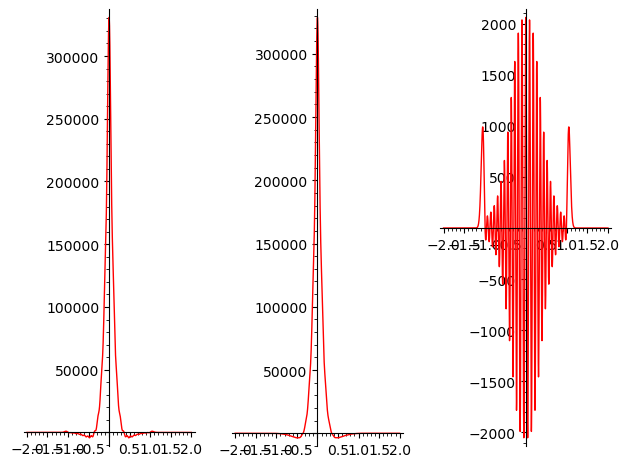

In [75]:
# Shows the relevancy of having a grid concentrated around a critical point

f=lambda_funcs[6]

res, app1, err = fit_num_ridge(f, basis_pts=grid(1,50),train_pts=grid(1,1000), basis_type='G', sigma=1/20, alpha=0 )
line1 = plot(app1, (x, -2, 2),color='red')
line2 = plot(f, (x, -5, 5),color='blue')

res, app2, err = fit_num_ridge(f, basis_pts=grid(1,50),train_pts=grid(1,1000), basis_type='G', sigma=1/20)
line3 = plot(app2, (x, -2, 2),color='red')
line4 = plot(f, (x, -5, 5),color='blue')
line9 = plot(app1-app2, (x, -2, 2),color='red')

show(graphics_array([line1, line3,line9], nrows=1))

In [25]:
def eta(x_i,x):
    return lambda_funcs[0](x-x_i)
def eta_2(x_i,x):
    return lambda_funcs[0](x-x_i) + lambda_funcs[2](x-x_i) + lambda_funcs[4](x-x_i) - lambda_funcs[6](x-x_i)
def eta_3(x, y, filt_eps=RBF(0.1)):
    z = RBF(y - x)
    a = abs(z)
    s = sign(z)
    eta = RBF((pi/4)*(2*pi**2*z**2 + 3*pi*a + 1.5)*exp(-2*pi*a))
    eta_2 = RBF((pi/4)*(-8*pi**3*z + 6*pi**2*s)*exp(-2*pi*a))
    eta_4 = RBF((pi/4)*(16*pi**5*z**2 - 24*pi**4*a + 6*pi**3)*exp(-2*pi*a))
    eta_6 = RBF((pi/4)*(-32*pi**7*z**3 + 72*pi**6*z*s - 36*pi**5*z)*exp(-2*pi*a))
    return RBF(exp(-a/RBF(filt_eps))) * RBF(eta - RBF(0.1)*eta_2 + RBF(0.01)*eta_4 - RBF(0.001)*eta_6)

def compute_approx_kernel(K,x1,x2,y1,y2,n_riem,n_basis,n_train,sigma=1/2, basis_type='G',concentrate=False):
    riemann_points=grid(y1,n_riem,y2)
    train_pts=grid(x1,n_train,x2)
    c = [[0 for j in range(n_basis)] for i in range(n_riem)] # c[i] is the list of the coefficients of the gaussian kernel that approximates K(x,y_i)
    if concentrate :
        basis_grid=[grid_concentrated(x1,x2,riemann_points[i],n_basis) for i in range(n_riem)]
    else :
        basis_grid=[grid(x1,n_basis,x2) for i in range(n_riem)]
    errors=[]
    for i in range(n_riem):
        coefficients, _, mse = fit_num(lambda x: K(x,riemann_points[i]), basis_grid[i], train_pts, sigma, basis_type)
        c[i]=coefficients 
        errors.append(mse)
        sys.stdout.write(f"\rCoefficients computation : {int((i/n_riem) * 100)}%") # Progress bar
        sys.stdout.flush()
    sys.stdout.write("\r" + " " * 30 + "\r")
    sys.stdout.flush()
    print(f"MSE max = {max(errors)} ; MSE average: {mean(errors)}")
    def K_approx(x,y):
        s=RBF(0)
        for i in range(n_riem):
            for j in range(n_basis):
                s+= RBF(c[i][j])*RBF(G(x, basis_grid[i][j], sigma))*eta(riemann_points[i],y) 
        return s*((y2-y1)/n_riem) #THE DELTA WAS MISSING HERE !!
    return K_approx


Some examples of kernel approximation
---

In [27]:
# First example with a nice function. We can observe that despite the fact that the gaussian kernel converges quite fast to a relevant approximation, the rate of convergence is pretty slow :
# L^2 error for a 20x20 grid : [0.24213298354645611527009855379086081525972906766468991270626727048507704464817209359 +/- 4.99e-84]
# L^2 error for a 40x40 grid : [0.1974516062190444277100886883318386625328517213038835652180062289031507379219911395 +/- 3.23e-83]
# L^2 error for a 80x80 grid : [0.188610547052896253372045283291878139980266698584153672865610066685072596406232665349 +/- 7.58e-85]

A=4
K=fast_callable(sin(x)*cos(y),vars=[x,y],domain=RBF)
K_approx = compute_approx_kernel(K,-A,A,-A,A,20,20,500,1)

print(f"L^2 norm of the difference = {riemann_integral(delta_squared(K,K_approx),-A,A,-A,A,40)}")

plot1=plot3d(sin(x)*cos(y),(x,-A,A),(y,-A,A),color='blue')
plot2=plot3d(K_approx,(x,-A,A),(y,-A,A),color='red')
plot3=plot3d(delta_squared(K,K_approx),(x,-A,A),(y,-A,A),color='purple')
L=[plot1,plot2,plot1+plot2,plot3]
h = sum(L[i].translate((i*(2*A+1),0,0)) for i in range(len(L)))
h.show()

⚠️ Warning: condition number = 703413084.3625222, result may be unstable.
Coefficients computation : 0%⚠️ Warning: condition number = 703413084.3625222, result may be unstable.
Coefficients computation : 5%⚠️ Warning: condition number = 703413084.3625222, result may be unstable.
Coefficients computation : 10%⚠️ Warning: condition number = 703413084.3625222, result may be unstable.
Coefficients computation : 15%⚠️ Warning: condition number = 703413084.3625222, result may be unstable.
Coefficients computation : 20%⚠️ Warning: condition number = 703413084.3625222, result may be unstable.
Coefficients computation : 25%⚠️ Warning: condition number = 703413084.3625222, result may be unstable.
Coefficients computation : 30%⚠️ Warning: condition number = 703413084.3625222, result may be unstable.
Coefficients computation : 35%⚠️ Warning: condition number = 703413084.3625222, result may be unstable.
Coefficients computation : 40%⚠️ Warning: condition number = 703413084.3625222, result may be un

Graphics3d Object

In [12]:
# Shows that for a function that has a sharp increase around the edges of the approximation domain, it is better to approximate on a wider domain, even if is with the same number of gaussians and thus a worst MSE error.

A=1
B=2
K=fast_callable(x**3 +y**2,vars=[x,y],domain=RBF)
K_approx1 = compute_approx_kernel(K,-A,A,-A,A,15,15,1000,1)
K_approx2 = compute_approx_kernel(K,-B,B,-B,B,15,15,1000,1)

print(f"L^2 norm of the difference learned on the small domain = {riemann_integral(delta_squared(K,K_approx1),-A,A,-A,A,50)}")
print(f"L^2 norm of the difference learned on the big domain = {riemann_integral(delta_squared(K,K_approx2),-A,A,-A,A,50)}")

plot1=plot3d(x**3 +y**2,(x,-A,A),(y,-A,A),color='blue')
plot2=plot3d(K_approx1,(x,-A,A),(y,-A,A),color='red')
plot3=plot3d(K_approx2,(x,-A,A),(y,-A,A),color='red')
plot4=plot3d(delta_squared(K,K_approx1),(x,-A,A),(y,-A,A),color='purple')
plot5=plot3d(delta_squared(K,K_approx2),(x,-A,A),(y,-A,A),color='purple')
L=[plot1+plot2,plot4,plot1+plot3,plot5]
h = sum(L[i].translate((i*(2*A+1),0,0)) for i in range(len(L)))
h.show()

MSE max = 1.962421181500127e-12 ; MSE average: 1.9623975628568626e-12
MSE max = 2.4736758044268315e-10 ; MSE average: 2.473345036062135e-10
L^2 norm of the difference learned on the small domain = [0.2290184130867956741200618895211162752253968214046517512359927450265992107351613790 +/- 9.01e-83]
L^2 norm of the difference learned on the big domain = [0.059579273669439121803746852518307649784008865239149397545920418525593288773113514 +/- 6.30e-82]


Graphics3d Object

In [ ]:
# L^2 norm of the kernel on [-1,1]x[-1,1] = [133184377.97029109084252063996471540429154453286521468500387428956233104601941883554 +/- 8.27e-75]
# L^2 norm of the difference on [-1,1]x[-1,1] = [131354647.55096026783485651175729485990453503817095921034377021849013400102470583966 +/- 4.87e-75]

A=RBF(1)
B=RBF(1.5)
K=M_0_func
K_approx = compute_approx_kernel(K,-B,B,-B,B,30,30,500,1/5)

print(riemann_integral(delta_squared(K,K_approx),-A,A,-A,A,50))

In [ ]:
# Convergence away from zero :
# L^2 norm of the kernel on [10,12]x[10,12] = [0.0010092916923795511366695502161549058852235974268804438998524792498315717801139176994807 +/- 3.18e-89]
# L^2 norm of the difference on [10,12]x[10,12] = [0.00012355900719952420240488209659077634751891724494739469294537574928294750352109 +/- 4.48e-81]

x1=10
x2=12
y1=10
y2=12

K=M_0_func
K_approx = compute_approx_kernel(K,x1,x2,y1,y2,30,30,500,1)

print(riemann_integral(delta_squared(K,lambda x,y:0),x1,x2,y1,y2,40))
print(riemann_integral(delta_squared(K,K_approx),x1,x2,y1,y2,40))

plot1=plot3d(K,(x,x1,x2),(y,y1,y2),color='blue')
plot2=plot3d(K_approx,(x,x1,x2),(y,y1,y2),color='red')
plot3=plot3d(delta_squared(K,K_approx),(x,x1,x2),(y,y1,y2),color='purple')
L=[plot1,plot2,plot1+plot2,plot3]
h = sum(L[i].translate((3*i,0,0)) for i in range(len(L)))
h.show()


MSE max = 3.568164853087532e-08 ; MSE average: 1.1596160173393079e-08
[0.0010092916923795511366695502161549058852235974268804438998524792498315717801139176994807 +/- 3.18e-89]
[0.00012355900719952420240488209659077634751891724494739469294537574928294750352109 +/- 4.48e-81]


Graphics3d Object

In [1]:
x1=2
x2=3
y1=0
y2=1

K=lambda x,y: M_0_func(x,y)
K_approx = compute_approx_kernel(K,x1,x2,y1,y2,10,10,100,1)

print(riemann_integral(delta_squared(K,lambda x,y:0),x1,x2,y1,y2,40))
print(riemann_integral(delta_squared(K,K_approx),x1,x2,y1,y2,40))

# show(plot3d(K,(x,x1,x2),(y,y1,y2),color='blue'))
# show(plot3d(K_approx,(x,x1,x2),(y,y1,y2),color='red'))

NameError: name 'compute_approx_kernel' is not defined

In [7]:

show(plot3d(K,(x,x1,x2),(y,y1,y2),color='blue'))
show(plot3d(K_approx,(x,x1,x2),(y,y1,y2),color='red'))

Graphics3d Object

Graphics3d Object

In [64]:
x1=-1
x2=1
y1=-1
y2=1

K=lambda x,y: 1/((RBF(x)-RBF(y))**2 +RBF(1e-1))
K_approx = compute_approx_kernel(K,x1,x2,y1,y2,30,30,1000,1/2)

print(riemann_integral(delta_squared(K,lambda x,y:0),x1,x2,y1,y2,30))
print(riemann_integral(delta_squared(K,K_approx),x1,x2,y1,y2,30))

# plot1=plot3d(K,(x,x1,x2),(y,y1,y2),color='blue')
# plot2=plot3d(K_approx,(x,x1,x2),(y,y1,y2),color='red')
# plot3=plot3d(delta_abs(K,K_approx),(x,x1,x2),(y,y1,y2),color='purple')
# L=[plot1,plot2,plot1+plot2,plot3]
# h = sum(L[i].translate((3*i,0,0)) for i in range(len(L)))
# h.show()

MSE max = 0.0004166366438154052 ; MSE average: 0.0001528821985208887
[89.5026987392285765114781957359478071487944239996136862353518664383658004974729287880550 +/- 3.71e-86]
[11.51640945873016836445822817370278104422881402148836118588653396115152378119214 +/- 7.81e-78]
